# Modeling the scattering and the pulse profiles using shapelets in the time domain


In [1]:
from __future__ import print_function, division
import sys
!{sys.executable} -m pip install ultranest


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [125]:
import psrchive as p
import pylab
import scipy
from scipy.special import factorial
import numpy as np
import math
from multiprocessing import Pool
from ultranest import ReactiveNestedSampler, stepsampler
import os
from ultranest.plot import cornerplot
from pypolychord.priors import UniformPrior, GaussianPrior, LogUniformPrior

In [130]:
class Scattering():
    def __init__(self, filename, nchan=2, incScatter=True, incScatter_index=False, Nshapelets=1, have_EFAC=False):
    
        self.pDM = (1,500)
        self.pSc = (-6,-1) # en log -> 10-6 a 10-1 s a 1 GHz -> 1us a 100 ms.
        self.pSci = (-5,-2)
        self.pEFAC = (0.5,10)
        self.incScatter = incScatter
        self.incScatter_index = incScatter_index
        self.Tau_index = -3.6 # Default fixed value for the scattering index
        self.reffreq = 1 # Reference frequency of 1 GHz
        #self.nDM = 1
        self.nScatter = 1
        self.nfiles = 1
        self.labels = []
        self.have_EFAC = have_EFAC
        
        self.set_data(filename, nchan)
        self.set_NShapelets(Nshapelets)
        self.set_labels()

    def set_pDM(self, pDM):
        self.pDM = pDM
        
    def set_pSc(self, pSc):
        self.pSc = pSc
        
    def set_pSci(self, pSci):
        self.pSci = pSci
        
    def set_pEFAC(self, pEFAC):
        self.pEFAC = pEFAC
        
    def set_labels(self):
        self.labels.extend(["width"])
        self.labels.extend(['phi0_%d'%i for i in range(self.nfiles)])
        self.labels.extend(['amp_%d'%i for i in range(self.nchan)])      
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            self.labels.extend(["DM"])
            
        # Scattering time scale at reffreq
        if self.incScatter:
            self.labels.extend(['Tau_%d'%i for i in range(self.nScatter)])
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            self.labels.extend(["Tau_idx"])
        
        # Shapelets amplitudes (for n>1)
        if self.Nmax:
            self.labels.extend(['Samp_%d'%i for i in range(self.Nmax)]) 
        
        if self.have_EFAC:
            self.labels.extend(["EFAC"])
        #else: Samp = np.array([]) 
        #print (self.labels)
    
    def get_labels(self):
        return self.labels
    
    def fft_rotate(self, arr, phase):
        """
        fft_rotate(arr, phase):  (Taken from PRESTO by Scott Ransom)
            Return array 'arr' rotated by 'phase' to the left.  The
                rotation is done in the Fourier domain using the Shift Theorem.
                'phase' is between 0 and 1.  The resulting vector will have
                the same length as the original.
        """
        arr = np.asarray(arr)
        freqs = np.arange(arr.size / 2 + 1, dtype=float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return np.fft.irfft(phasor * np.fft.rfft(arr), arr.size)
    
    def rotate(self, arr, phase):
        """                                                                         
        fft_rotate(arr, phase):                                                      
            Return array 'arr' rotated by "phase" to the left.  The           
                rotation is done using the Shift Theorem assuming arr is in freq domain.     
                'phase' is fractional between 0 and 1.  The resulting vector will have           
                the same length as the original.                                    
        """
        freqs = np.arange(arr.size, dtype=float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return arr * phasor

    def PBF(self, f, tau, nu, alpha):
        """
        Pulse broadening function(f, tau, nu, alpha):
            Return the Fourier pulse broadening function given by Lentati et al.2017:
             - f: Fourier frequencies
             - tau: the scattering time scale
             - nu: the observing frequency
             - alpha: the scattering index
        """
        twopifnu = 2*np.pi*f* nu**alpha * 10**tau
        return 1/(twopifnu**2 + 1) + 1j*(-twopifnu)/(twopifnu**2 +1)


    def set_NShapelets(self, Nmax):
        # Number of shapelets coefficients
        self.Nmax = Nmax - 1 # The first shapelet coefficient is set to 1 
        self.Scoeff = np.arange(self.Nmax + 1)
    
        # Construct array of Hermite polynomials
        self.hermit_ar = []
       
        for n in self.Scoeff:
            self.hermit_ar.append(scipy.special.hermite(n))
    
    def Prior(self, cube):
        
        #print(cube)
        
        pcube = np.zeros(cube.shape)
        ipar = 0
        
        # Shapelet width
        pcube[ipar] = LogUniformPrior(2e-4,5e-3) (cube[ipar]); ipar +=1
        #pcube[ipar] = 10**((cube[ipar]*2)-3) * self.period; ipar +=1
        
        # Shapelet profile phase phi0 (0->1)
        pcube[ipar] = GaussianPrior(self.initphase, 0.01) (cube[ipar]); ipar += 1
        #pcube[ipar] = cube[ipar]; ipar += 1
        
        # Overall Shapelet scaling factor
        #pcube[ipar:ipar+self.nchan] = 10**(-2 + 3*cube[ipar:ipar+self.nchan]); ipar += self.nchan
        pcube[ipar:ipar+self.nchan] = 0.8 + cube[ipar:ipar+self.nchan]*.2; ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            #pcube[ipar:ipar+self.nDM] = cube[ipar:ipar+self.nDM] * (self.pDM[1] - self.pDM[0]) + self.pDM[0]
            pcube[ipar] = GaussianPrior(self.pDM[0], self.pDM[1]) (cube[ipar])
            ipar += 1
            
        # Scattering time scale at XXX
        if self.incScatter:
            pcube[ipar:ipar+self.nScatter] = (cube[ipar:ipar+self.nScatter] * (self.pSc[1] - self.pSc[0]) + self.pSc[0])
            ipar += 1
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            pcube[ipar] = GaussianPrior(-3.8,0.1) (cube[ipar])
            ipar += 1    
        
        # Shapelets amplitudes
        if self.Nmax:
            pcube[ipar:ipar+self.Nmax] = cube[ipar:ipar+self.Nmax]*5-2.5; ipar += self.Nmax
            
        # EFAC    
        if self.have_EFAC:
            pcube[ipar] = cube[ipar] * (self.pEFAC[1] - self.pEFAC[0]) + self.pEFAC[0]
            ipar += 1

        # TODO: should add baseline offsets
        #print (pcube)    
        return pcube
        
    def set_data(self, filename, nchan=4):
        print(filename)
        self.prof = None
        self.wts = None
        self.period = None
        self.obsfreq = None
        self.prof_stds = None
        self.nbin = None
        self.data = None
        
        
        fn = filename
        try:
            arch = p.Archive_load(fn)
        except:
                raise
        self.nchan = nchan
        print("Tscrunching archive...")
        arch.tscrunch()
        arch.bscrunch(2)
        print("Fscrunching archive to %d chans..."%nchan)
        arch.fscrunch_to_nchan(nchan)
        arch.pscrunch()
        arch.remove_baseline()
        self.aDM = arch.get_dispersion_measure()
        self.reffreq = arch.get_centre_frequency()
        
   
        integ = arch.get_first_Integration()
        
        # Get data
        self.data = arch.get_data()[0][0]
        maximums = np.max(self.data,axis=1)
        maximums = np.where(maximums==0, 1, maximums)
        
        # Get weights
        self.wts = arch.get_weights()[0]
        
        # Normalize the data
        self.prof = np.multiply(self.data.T, 1/maximums).T
        self.profT = self.prof.T
        
        # Get pulsar's period
        self.period = integ.get_folding_period()
        
        # Get channel frequencies
        self.obsfreq = arch.get_frequencies()/1000.
        print ("Frequencies:", self.obsfreq)
        
        # Get baseline RMS (1) for total intensity (0)
        stats = np.sqrt((integ.baseline_stats()[1][0])/maximums)
        stats = np.where(stats==0, 1., stats)
        
        # Rescale the RMS due to normalization above
        self.prof_stds = stats
        
        #pylab.plot(self.prof)
        #print(self.prof_stds)
        
        # Get number of profile bins
        self.nbin = arch.get_nbin()
        
        # Create the time array (from -P/2 to +P/2)
        self.nu = np.arange(self.nbin, dtype=float) / self.nbin * self.period  - self.period/2.
        #print(self.prof, self.nu, self.prof_stds)    
        
    def plot_profiles(self):
        # Plot the data
        pylab.xlabel("Pulse phase (bins)")
        pylab.subplot(2, 1, 1)
        for ichan in range(self.nchan):
            pylab.plot((self.prof[ichan]+ichan))
        # Plot the model
        
        pylab.subplot(2, 1, 2)
        for ichan in range(self.nchan):
            pylab.plot((self.model[ichan]+ichan))
        #pylab.savefig("profiles_1851A.pdf")    
        
    def shapelet_profile(self, Samp, width):

        nu_width = self.nu * width**-1
        
        # First shapelet has amplitude of 1
        n = 0
        model = 1 * width**-.5 * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5 * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width)
        
        #print (self.Scoeff, Samp)
        # TODO: we could remove the first coefficient from the parameters to sample
        for n in self.Scoeff[1:]:
            model += Samp[n-1] * width**-.5 * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5 * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width)
        return model
    
    def prof_to_ref_freq(self):
        #print(self.aDM, self.period)
        prof_tot = np.zeros(self.prof[0].size)
        for ichan in range(self.nchan):
            delay_phase = math.modf(self.aDM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)[0];
            #print(ichan, delay_phase)
            prof_rot = self.fft_rotate(self.prof[ichan], delay_phase)
            pylab.plot((prof_rot+ichan))
            prof_tot += prof_rot
        
        pylab.plot((prof_tot+ichan+1))
        # Shapelets are built at the center of the pulse window
        self.initphase = 0.5 - np.argmax(prof_tot)/self.prof[0].size
        while self.initphase < 0.:
            self.initphase += 1
        print(self.initphase)
        
    def LogLikelihood(self, cube, DEBUG=False):
        
        logdet = 0.
        
        ## ASSIGN VARIABLES ##
        ipar = 0
        width = cube[ipar]; ipar +=1
        
        phi0 = cube[ipar]; ipar += 1
        
        Amp = cube[ipar:ipar+self.nchan]; ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            #DM = cube[ipar:ipar+self.nDM]; ipar += self.nDM
            DM = cube[ipar]; ipar += 1
            
        # Scattering time scale at XXX
        if self.incScatter:
            Tau = cube[ipar:ipar+self.nScatter]; ipar += self.nScatter
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            self.Tau_index = cube[ipar]; ipar += 1
        
        # Shapelets amplitudes (for n>1)
        if self.Nmax:
            Samp = cube[ipar:ipar+self.Nmax]; ipar += self.Nmax
        else: Samp = np.array([]) 
            
        if self.have_EFAC:    
            EFAC = cube[ipar]; ipar +=1
        else:
            EFAC = 1

        # Construct the profile model with Shapelets amplitude and widths. Todo: should add more than 1 Shapelet
        model = self.shapelet_profile(Samp, width)
 
        # FFT the model
        fftmodel_freqs = np.arange(model.size / 2 + 1, dtype=float) / ( self.period)
        self.fftmodel = np.fft.rfft(model)
        
        self.model = np.zeros((self.nchan, self.nbin))
    
        # For each channel, rotate given phase and dispersion, then scatter
        for ichan in range(self.nchan):
            # Discard any subband with zero weight
            if not self.wts[ichan]:
                continue
            
            # Get the DM delay phase (fractional part of the DM delay/period )
            if nchan > 1:
                delay_phase = math.modf(DM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)[0];
                #print("freq:",self.obsfreq[ichan])
                #print("ichan",ichan)
                #print("delay_phase", delay_phase)
            else: delay_phase = 0
            
            # Apply DM delay to phase offset
            #print(self.obsfreq[ichan], delay_phase, DM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)
            phase_off = phi0-delay_phase
            while phase_off < 0:
                phase_off += 1
                
            # Rotate
            ifftmodel = self.rotate(self.fftmodel, phase_off)
        
            # Scatter the model
            if self.incScatter:
                ifftmodel *= self.PBF(fftmodel_freqs, Tau, self.obsfreq[ichan], self.Tau_index)
        
            # FFT back the model for each channel
            self.model[ichan] = np.fft.irfft(ifftmodel, model.size)
            self.model[ichan] /= np.max(self.model[ichan])
            
            if self.have_EFAC:
                logdet += np.log((self.prof_stds[ichan] * EFAC )**2)

        # Apply overall scaling factor
        #print (self.model.shape, Amp.shape)
        self.model = (self.model.T * Amp).T
        
        self.modelc = self.model.T
            
                 

        chi = np.sum((self.modelc-self.profT)**2/(self.prof_stds)**2)
        
        return -0.5 * chi -0.5*logdet
             


In [141]:
### THIS IS THE ONLY CELL WHERE WE SET THE PARAMETERS ###

# Set the number of shapelets (1 is basically a gaussian)
Nshapelets = 1
# Set the number of channels
nchan = 8

# Set the location of the filename
#filename = "/Users/gdesvignes/nsub16/2205.ar.T"
#filename = "/Volumes/DATASSD/2205+6015/Nancay/data/nuppi_59010_2205+6015_257963.dm3"
#filename = "/data/scattering/fold_n128_04_PSR_0514-4002A.ar.pazi.pazi"
#filename = "/data/tasha/fold_PSR_1748-2446A.ar"
#filename = "/data/scattering/scatter_JBO_simulation1_13.ar"
filename = "/data/SPAN512/discoveries/J2205+6015/Nancay/new_tpl/sum.ar.newtpl.DD"
filename = "/data/scattering/MGPS/J1227-6208_2020-05-05-19:02:32_zap.ch.fluxcal.profile_ready"
filename = "/data/SRVGC/transientX/SRVGC25/test/SP_58871.3789783033_cfbf00000_03_01.nchn16"
filename = "/data/SRVGC/transientX/SRVGC25/test/sum.ar"
filename = "/data/magnetar-1745-2858/SPs/20180716_45mm/transientX/SP_58315.8690312109_cfbf00000_01_01.ar"

# Set the prior for DM
DMr = (157.2,157.8)
DMr = (362, 364)
DMr = (4542, 4555)
DMr = (1776,1)
#DMr_L = (237.50,237.54)
#DMr = (2200,2260)
#DMr = 237.017499   #Ter5C
# Set the prior for the scattering time scale at 1 GHz in s, in log unit
Tau_sc = (0,1)
#Tau_sc = (-1,2)

# Set the prior for scattering index
#Tau_idx = (-5,-2)
#Tau_idx = -4.0

# Fit for scattering? 
incScatter = True
#incScatter = False

# Fit for scattering index?

incScatter_index = False

have_EFAC = False



Ndim = 12

['Sw', 'Phi', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'DM', 'Tau_1']
/data/magnetar-1745-2858/SPs/20180716_45mm/transientX/SP_58315.8690312109_cfbf00000_01_01.ar
/data/magnetar-1745-2858/SPs/20180716_45mm/transientX/SP_58315.8690312109_cfbf00000_01_01.ar
Tscrunching archive...
Fscrunching archive to 8 chans...
Frequencies: [4.25 4.75 5.25 5.75 6.25 6.75 7.25 7.75]
0.87890625


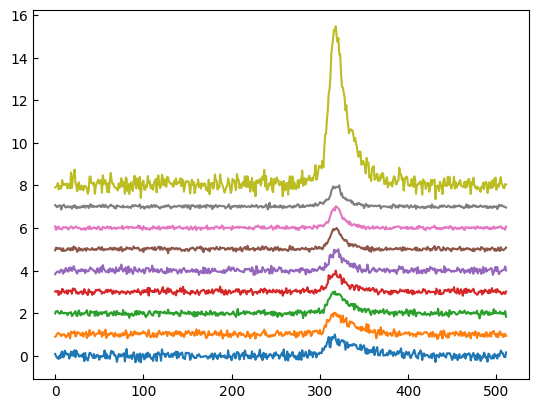

In [142]:
# RUN THE ANALYSIS
Ndim = 1 + 1 + nchan + (Nshapelets-1)
paramnames = ['Sw','Phi'] + ["A%d" %i for i in list(range(nchan))]
if nchan > 1:
    Ndim += 1
    paramnames += ['DM']
if incScatter == True:
    Ndim += 1
    paramnames += ['Tau_1']
if incScatter_index == True:
    Ndim += 1
    paramnames += ['Tau_idx']
    
paramnames += ["Sa%d" %i for i in list(range(Nshapelets-1))]

if have_EFAC == True:
    Ndim += 1
    paramnames += ['EFAC']
print("Ndim = %d\n"%Ndim)
print(paramnames)

print(filename)
model = Scattering(filename, nchan=nchan, Nshapelets=Nshapelets, incScatter=incScatter, incScatter_index=incScatter_index, have_EFAC=have_EFAC)

# Set the DM prior                                                                                                                                                                                
model.set_pDM(DMr)

# Set the prior for the scattering time scale at 1 GHz, in log unit                                                                                                                               
model.set_pSc(Tau_sc)

# Set the prior for the scattering index
#model.set_pSci(Tau_idx)

model.prof_to_ref_freq()

In [143]:
#sampler = dynesty.NestedSampler(model.LogLikelihood, model.Prior, Ndim, nlive=300)
#sampler.run_nested()
sampler = ReactiveNestedSampler(paramnames, model.LogLikelihood, transform=model.Prior, vectorized=False, log_dir="/data/scattering/MGPS/20200505")
nsteps = 3 * len(paramnames)
# create step sampler:
#sampler.stepsampler = stepsampler.RegionSliceSampler(nsteps=nsteps)
#sampler.stepsampler = stepsampler.RegionSliceSampler(nsteps=nsteps, adaptive_nsteps='move-distance')
sampler.stepsampler = stepsampler.SliceSampler(nsteps=nsteps, generate_direction=stepsampler.generate_mixture_random_direction)
result = sampler.run(min_num_live_points=400)
sampler.print_results()

Creating directory for new run /data/scattering/MGPS/20200505/run79
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+03  631.59 [-5633.3356..-5633.3351]*| it/evals=22640/2192449 eff=1.0328% N=400 
[ultranest] Likelihood function evaluations: 2192580
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -5685 +- 0.2725
[ultranest] Effective samples strategy satisfied (ESS = 4613.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.24 to 0.56, need <0.5)
[ultranest]   logZ error budget: single: 0.34 bs:0.27 tail:0.01 total:0.27 required:<0.50
[ultranest] done iterating.

logZ = -5684.939 +- 0.470
  single instance: logZ = -5684.939 +- 0.339
  bootstrapped   : logZ = -5685.014 +- 0.470
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    Sw                  : 0.001520│ ▁  ▁ ▁▁▁▁▁▁▂▃▄▅▆▇▇▇▇▇▆▆▄▃▃▂▂▁▁▁▁▁▁▁ ▁ 

In [2]:
10**0.2159

1.6439931362213211

In [62]:
#### Output values #####
idx = 2
if model.nchan > 1:
    print ("DM (pc cm^-3) :" , quantiles[idx+nchan][0], -quantiles[idx+nchan][0] + quantiles[idx+nchan][1], quantiles[idx+nchan][2] - quantiles[idx+nchan][0])
    idx += 1
print ("Scattering time at ref. freq. %.2f GHz (s): "%model.reffreq, 10**quantiles[idx+nchan][0], -10**(quantiles[idx+nchan][0]) + 10**(quantiles[idx+nchan][1]), 10**(quantiles[idx+nchan][2]) - 10**(quantiles[idx+nchan][1]))

tau = model.labels.index('Tau_0')


if model.incScatter_index:
    tau_idx = model.labels.index('Tau_idx')
    tau_idx = samples_equal.T[tau_idx]
else:
    tau_idx = model.Tau_index

#samples_equal.T[]
print("Scattering Index",model.Tau_index)
for f in model.obsfreq:
    #d = 10**samples_equal.T[tau] * (f/model.reffreq)**(samples_equal.T[tau_idx])
    d = 10**samples_equal.T[tau] * (f/model.reffreq)**(tau_idx)
    print("Scattering time @%.2f GHz (s): "%f, np.quantile(d, [0.5, 0.15865, 1-0.15865]))
    #print("Scattering time @%.2f GHz (s) 0.5 quantile: "%f, np.quantile(d, 0.5))

NameError: name 'quantiles' is not defined

/tmp/ipykernel_26921/3354847846.py:228: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pylab.subplot(2, 1, 1)


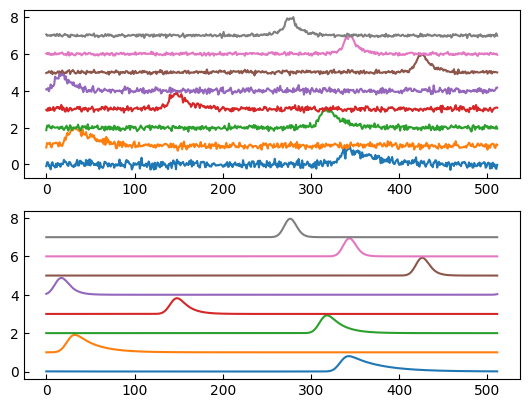

In [144]:
model.plot_profiles()

#dyplot.traceplot(dresults)
#cp = dyplot.cornerplot(dresults, color='blue', truths=np.zeros(Ndim),labels=model.get_labels())
#pylab.savefig("corner_plot_1851a.pdf")

In [57]:
DM = sampler.results['posterior']['mean'][-2]
DM

1773.5378577716665

In [72]:
#model.LogLikelihood(np.array([0.00001425,0.54706,1.,1.,1.,1., 157.50858,-3.5]))

-905.1755377872045

In [16]:
#sampler.results

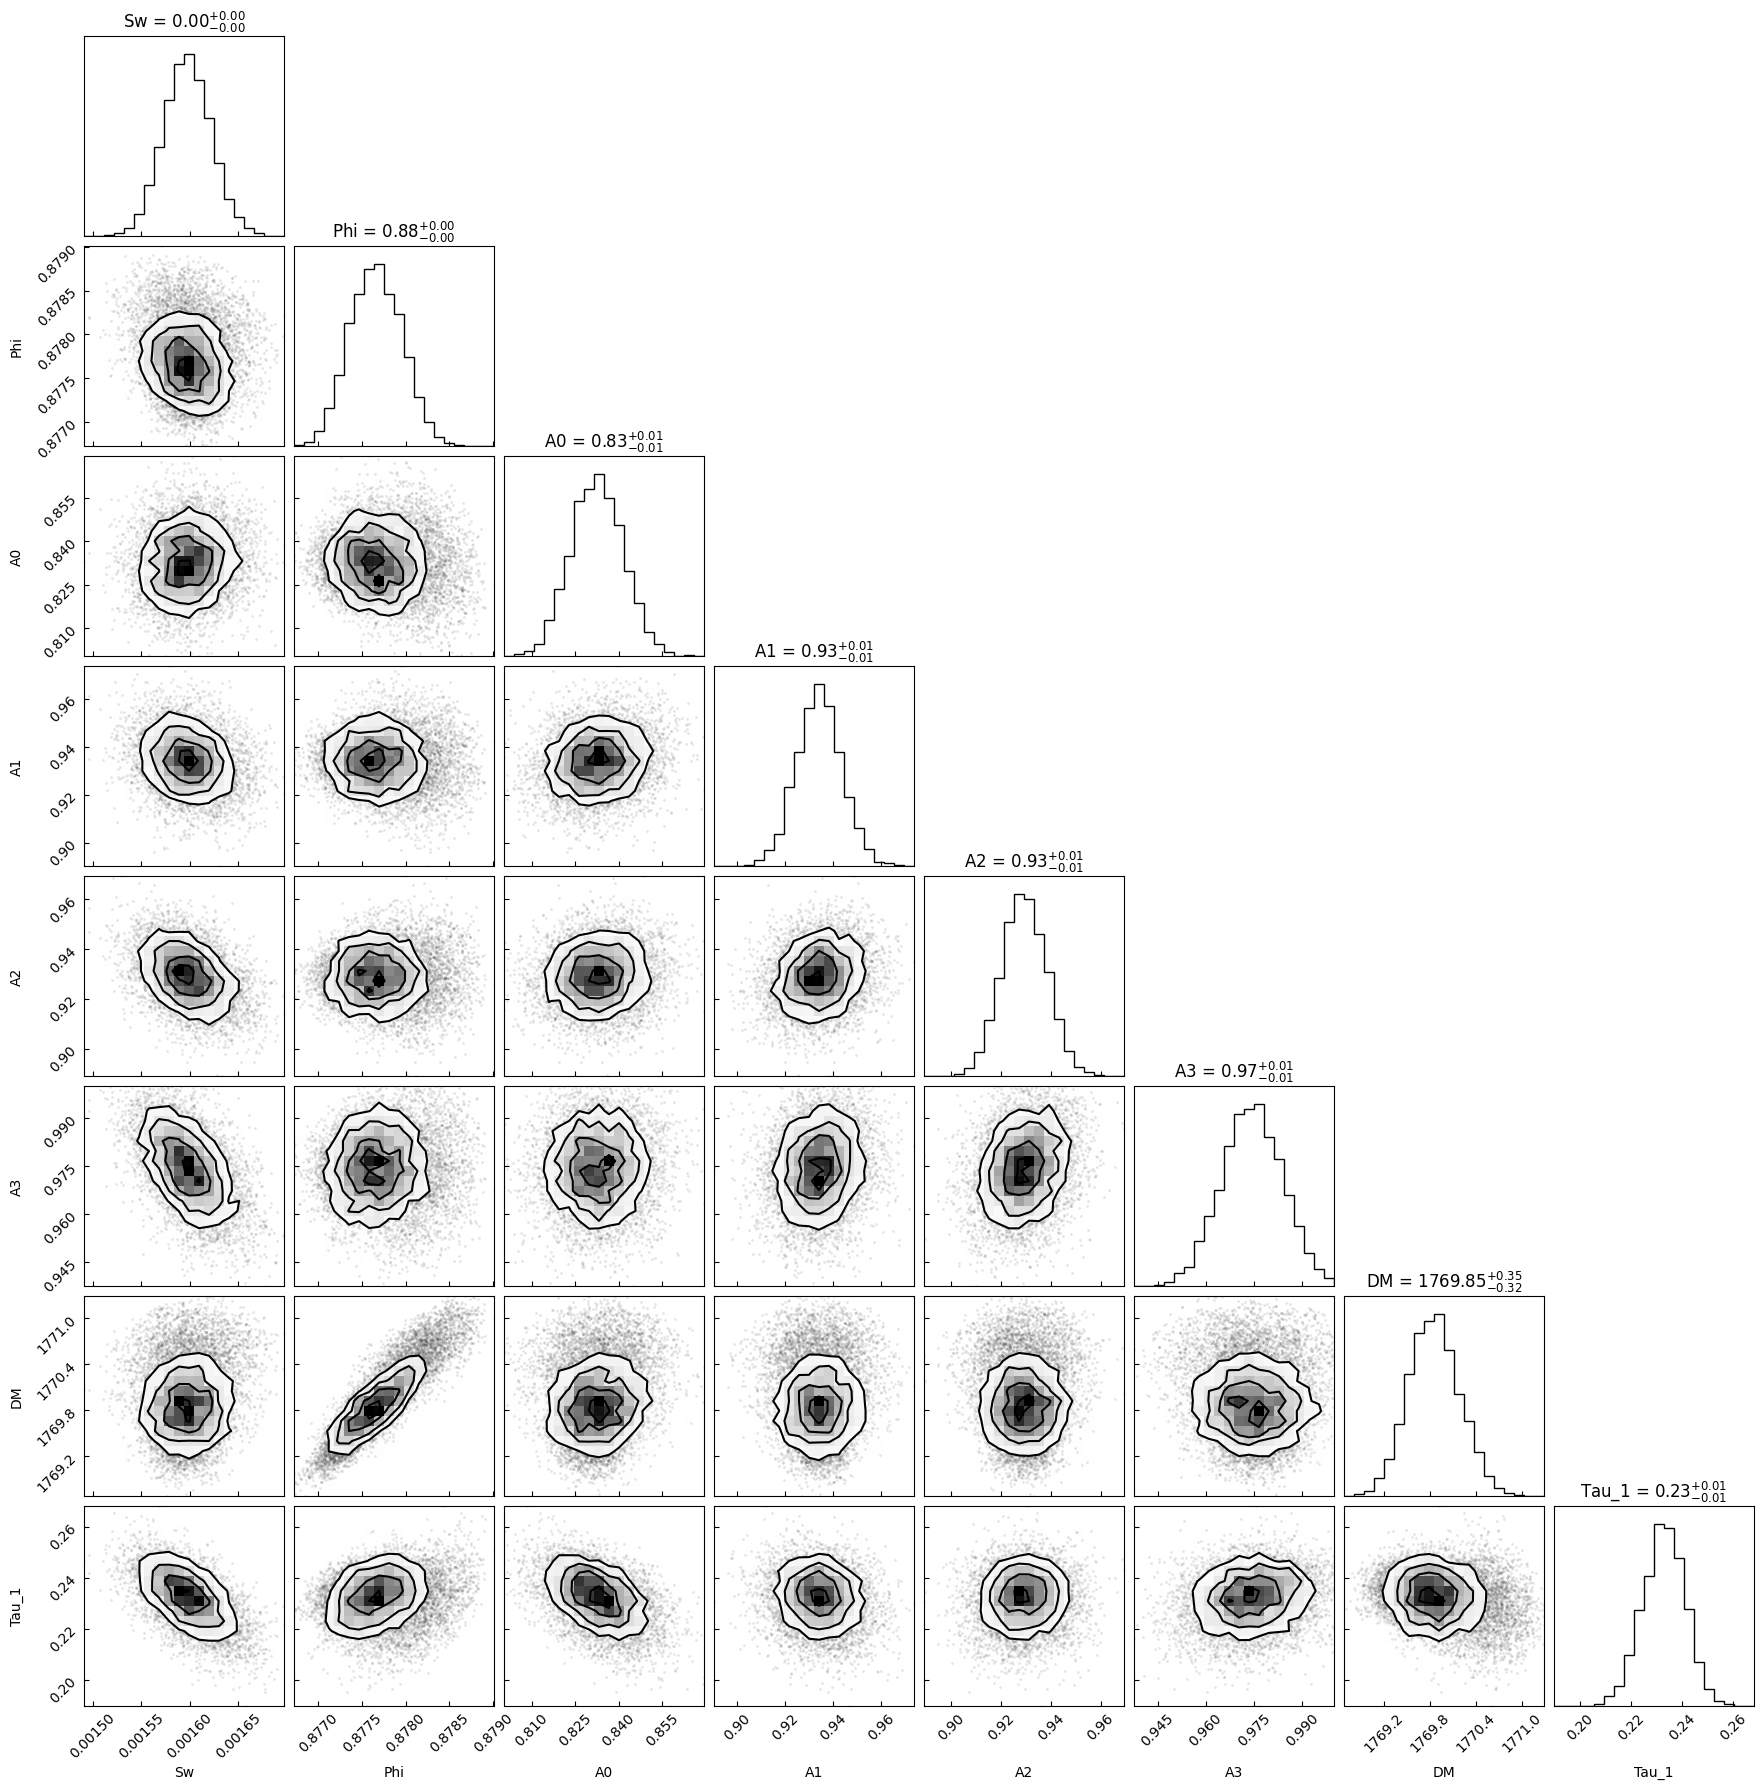

In [140]:
cornerplot(result)

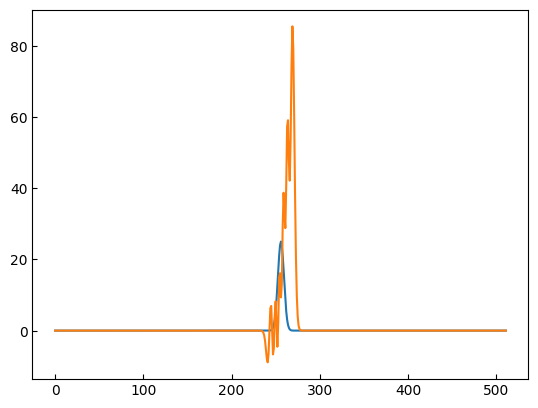

In [158]:
model.set_NShapelets(1)
pylab.plot(model.shapelet_profile(np.ones(5),9e-4))
model.set_NShapelets(12)
pylab.plot(model.shapelet_profile(np.ones(120),9e-4))
#pylab.plot(model.shapelet_profile([1,1,1],5e-3))
#pylab.xlim(240,280)